In [1]:
#!/usr/bin/python
import talib
import requests
import python_bitbankcc
import pandas as pd
import numpy as np
from datetime import datetime,date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
API = python_bitbankcc.public()
l = ['2015', '2016', '2017', '2018', '2019', '2020']
pair = 'btc_jpy'
period = '1day'
ohlcv = []
for year in l:
    ohlcv.extend(API.get_candlestick(pair, period, year)['candlestick'][0]['ohlcv'])
df = pd.DataFrame(ohlcv, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Time'])
df['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in df['Time']]
df.drop('Volume', axis=1, inplace=True)
df.set_index('Time',inplace=True)
df.tail()

,Open,High,Low,Close
Time,,,,
2020-07-30,1167600,1171169,1145111,1162614
2020-07-31,1162800,1215000,1147501,1201973
2020-08-01,1201781,1259199,1191006,1253600
2020-08-02,1253213,1286952,1160000,1174439
2020-08-03,1174438,1194242,1165000,1192000


In [3]:
df['Open'] = df['Open'].astype(np.int64)
df['High'] = df['High'].astype(np.int64)
df['Low'] = df['Low'].astype(np.int64)
df['Close'] = df['Close'].astype(np.int64)

In [4]:
from backtesting import Strategy
from backtesting.lib import crossover

def EMA_Backtesting(values, n):
    """
    Return exponential moving average of `values`, at
    each step taking into account `n` previous values.
    """
    close = pd.Series(values)
    return talib.EMA(close, timeperiod=n)

class Ema4CrossStrategy(Strategy):
    
    # Define the two EMA lags as *class variables*
    # for later optimization
    n1 = 8
    n2 = 15
    n_enter = 5
    n_exit = 3
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA_Backtesting, self.data.Close, self.n1)
        self.ema2 = self.I(EMA_Backtesting, self.data.Close, self.n2)
        self.ema_enter = self.I(EMA_Backtesting, self.data.Close, self.n_enter)
        self.ema_exit = self.I(EMA_Backtesting, self.data.Close, self.n_exit)
    
    def next(self):
        # if no positions are remained
        if not self.position:
            # On upward trend, if price closes above entry MA, go long
            if self.ema1 > self.ema2:
                if crossover(self.data.Close, self.ema_enter):
                    self.buy()
            
            # on downward trend, if price closes below entry MA, go short
            else:
                if crossover(self.ema_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) exit MA, close the position
        else:
            if (self.position.is_long and
                crossover(self.ema_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.ema_exit)):
                
                self.position.close()

/opt/conda/lib/python3.7/site-packages/backtesting/_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [5]:
from backtesting import Backtest
# start from 1 BTC with the commission 0.12%

df_ = df.copy()
bt = Backtest(df_, Ema4CrossStrategy, cash=1, commission=.0012)
bt.run()

Start                     2015-01-01 00:00:00
End                       2020-08-03 00:00:00
Duration                   2041 days 00:00:00
Exposure [%]                          35.6198
Equity Final [$]                      17.0668
Equity Peak [$]                       19.0757
Return [%]                            1606.68
Buy & Hold Return [%]                 3068.36
Max. Drawdown [%]                    -33.5249
Avg. Drawdown [%]                    -8.30323
Max. Drawdown Duration      638 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                  181
Win Rate [%]                          36.4641
Best Trade [%]                        87.9111
Worst Trade [%]                      -13.0087
Avg. Trade [%]                        1.88804
Max. Trade Duration          25 days 00:00:00
Avg. Trade Duration           5 days 00:00:00
Expectancy [%]                         5.3529
SQN                                   1.51523
Sharpe Ratio                      

In [6]:
bt.plot()

In [7]:
%time

n1=list(range(5, 20))
n2=list(range(15, 30))
n_enter=list(range(5, 10))
n_exit=list(range(2, 8))

stats, heatmap = bt.optimize(
    n1=n1,
    n2=n2,
    n_enter=n_enter,
    n_exit=n_exit,
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    return_heatmap=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Searching best of 3840 configurations.
  from ipykernel import kernelapp as app


In [8]:
print(stats)

Start                                                   2015-01-01 00:00:00
End                                                     2020-08-03 00:00:00
Duration                                                 2041 days 00:00:00
Exposure [%]                                                        43.3121
Equity Final [$]                                                    56.2956
Equity Peak [$]                                                     61.1479
Return [%]                                                          5529.56
Buy & Hold Return [%]                                               3068.36
Max. Drawdown [%]                                                  -39.5354
Avg. Drawdown [%]                                                  -8.93647
Max. Drawdown Duration                                    404 days 00:00:00
Avg. Drawdown Duration                                     45 days 00:00:00
# Trades                                                                195
Win Rate [%]

In [9]:
print(heatmap)

n1  n2  n_enter  n_exit
6   15  5        2          7.199939
                 3         14.460014
                 4         25.942568
    16  5        2          8.688975
                 3         17.151121
                             ...    
19  29  9        3          3.680845
                 4          3.131047
                 5          2.882616
                 6          6.810398
                 7          8.630511
Length: 3840, dtype: float64


In [10]:
heatmap.sort_values().iloc[-3:]

n1  n2  n_enter  n_exit
14  21  5        4         55.759427
15  20  5        4         55.759427
13  22  5        4         56.295623
dtype: float64

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


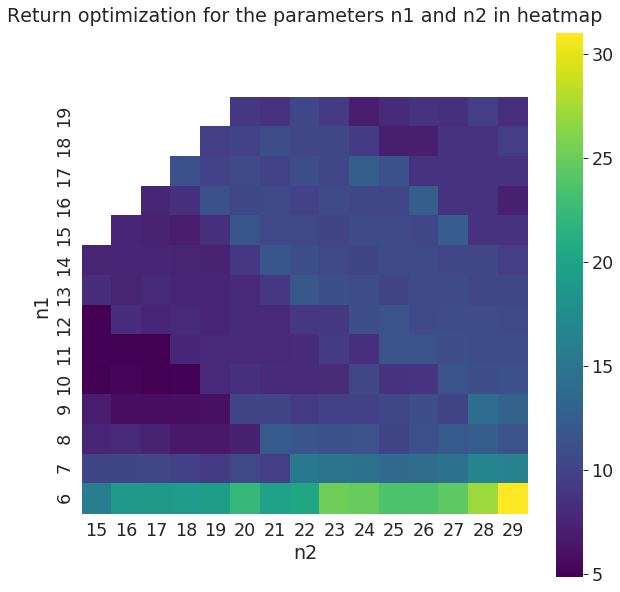

In [11]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("PuBu", 8)
sns.set_context(context='paper', font_scale=2, rc=None)

hm = heatmap.groupby(['n1', 'n2']).mean().unstack()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Return optimization for the parameters n1 and n2 in heatmap', pad=75)
sns.heatmap(hm[::-1], square=True, linecolor='white', ax=ax, cbar=True, cmap='viridis')

In [12]:
from backtesting.lib import plot_heatmaps
plot_heatmaps(heatmap, agg='mean')

Column(id='1880', ...)